#**Maestría en Inteligencia Artificial Aplicada**

##**Curso: Análisis de grandes volúmenes de datos**

###Tecnológico de Monterrey

###Dr. Iván Olmos Pineda

###Mtro. José Carlos Soto

## **Adtividad 5: Actividad de visualización de resultados**

## **Nombre y matrícula:**

Alexys Martín Coate Reyes			    A01746998 

Manuel Gerardo López Garza 		        A00821663 

Diego Andres Bernal Diaz			    A01795975 

Annette Cristina Narváez Andrade		A00571041 

In [1]:
# Importaciones necesarias
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, floor, count, when, lit, round, avg, sum, row_number
from pyspark.sql.window import Window

In [2]:
# Crear nueva sesión Spark con más memoria (si tu sistema lo permite)
spark = SparkSession.builder \
    .appName("ProyectoFinal") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

25/06/18 15:27:38 WARN Utils: Your hostname, MacBook-Pro-de-Annette.local resolves to a loopback address: 127.0.0.1; using 192.168.100.207 instead (on interface en0)
25/06/18 15:27:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/18 15:27:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
# Leer el dataset
df = spark.read.csv("Airline_Delay_2016-2018.csv", header=True, inferSchema=True)
print(f"Total de registros en el DataFrame: {df.count()}")


[Stage 8:================================>                         (9 + 7) / 16]

Total de registros en el DataFrame: 18505725


In [8]:
from pyspark.sql.functions import when, col

# 1. Filtrar vuelos válidos (no cancelados ni desviados)
df = df.filter((col("CANCELLED") == 0) & (col("DIVERTED") == 0))

# 2. Crear la columna binaria DELAYED antes de eliminar columnas
df = df.withColumn(
    "DELAYED",
    when(col("DEP_TIME") > col("CRS_DEP_TIME"), 1).otherwise(0)
)

# 3. Eliminar columnas no deseadas
cols_to_drop = [
    'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
    'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'DIVERTED', 'ACTUAL_ELAPSED_TIME',
    'AIR_TIME', 'OP_CARRIER_FL_NUM'
]
df = df.drop(*cols_to_drop)

# 4. Seleccionar columnas finales útiles (opcional, ya estás filtrando arriba)
cols_to_keep = [
    'FL_DATE', 'OP_CARRIER', 'ORIGIN', 'DEST',
    'CRS_DEP_TIME', 'CRS_ARR_TIME', 'DISTANCE', 'DELAYED'
]
df = df.select(*cols_to_keep)

# Verificación
df.show(5)
df.groupBy("DELAYED").count().show()


+----------+----------+------+----+------------+------------+--------+-------+
|   FL_DATE|OP_CARRIER|ORIGIN|DEST|CRS_DEP_TIME|CRS_ARR_TIME|DISTANCE|DELAYED|
+----------+----------+------+----+------------+------------+--------+-------+
|2016-01-01|        DL|   DTW| LAX|        1935|        2144|  1979.0|      0|
|2016-01-01|        DL|   ATL| GRR|        2125|        2321|   640.0|      1|
|2016-01-01|        DL|   LAX| ATL|        2255|         600|  1947.0|      1|
|2016-01-01|        DL|   SLC| ATL|        1656|        2229|  1590.0|      1|
|2016-01-01|        DL|   BZN| MSP|         900|        1216|   874.0|      1|
+----------+----------+------+----+------------+------------+--------+-------+
only showing top 5 rows



[Stage 12:================================>                        (9 + 7) / 16]

+-------+--------+
|DELAYED|   count|
+-------+--------+
|      1| 6219951|
|      0|11976610|
+-------+--------+



In [9]:
from pyspark.sql.functions import (
    to_date, dayofweek, month, hour, when, floor, col, udf
)
from pyspark.sql.types import StringType

# Asegurar que FL_DATE esté en formato fecha
df = df.withColumn("FL_DATE", to_date(col("FL_DATE"), "yyyy-MM-dd"))

# 1. Día de la semana (1 = domingo, 7 = sábado)
df = df.withColumn("DAY_OF_WEEK", dayofweek(col("FL_DATE")))

# 2. Fin de semana (1 = sábado o domingo)
df = df.withColumn("IS_WEEKEND", when(col("DAY_OF_WEEK").isin([1, 7]), 1).otherwise(0))

# 3. Estación del año (según el mes)
@udf(StringType())
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df = df.withColumn("MONTH", month(col("FL_DATE")))
df = df.withColumn("SEASON", get_season(col("MONTH")))

# 4. Hora estimada de salida (entera) a partir de CRS_DEP_TIME
df = df.withColumn("DEP_HOUR", floor(col("CRS_DEP_TIME") / 100))

# 5. Hora pico (definidas como 6–9h, 15–19h)
df = df.withColumn("IS_PEAK_HOUR", when(col("DEP_HOUR").between(6, 9) | col("DEP_HOUR").between(15, 19), 1).otherwise(0))


In [10]:
from pyspark.sql.functions import col, count, floor, rand, row_number
from pyspark.sql.window import Window

# 1. Asegurar que DEP_HOUR está creada
df = df.withColumn("DEP_HOUR", floor(col("CRS_DEP_TIME") / 100))

# 2. Definir columnas clave para particiones Mi
group_cols = ["OP_CARRIER", "ORIGIN", "DEST", "DEP_HOUR"]

# 3. Calcular tamaño total de población
total_count = df.count()

# 4. Calcular tamaño de la muestra (1%)
sample_target = int(total_count * 0.01)

# 5. Contar frecuencia de cada combinación Mi
grouped = df.groupBy(group_cols).agg(count("*").alias("group_count"))

# 6. Calcular probabilidad relativa de cada grupo
grouped = grouped.withColumn("group_prob", col("group_count") / total_count)

# 7. Calcular tamaño de muestra por grupo
grouped = grouped.withColumn("sample_size", (col("group_prob") * sample_target).cast("int"))

# 8. Unir con el dataset original
df_keys = df.join(grouped, on=group_cols, how="inner")

# 9. Usar ventana para seleccionar primeros N registros por grupo
window_spec = Window.partitionBy(*group_cols).orderBy(rand(seed=42))
df_sample = df_keys.withColumn("row_number", row_number().over(window_spec)) \
                   .filter(col("row_number") <= col("sample_size"))

# 10. Muestra final limpia
df_muestra_final = df_sample.drop("row_number", "group_count", "group_prob", "sample_size")

# 11. Verificación
df_muestra_final.groupBy("DELAYED").count().show()
print("Tamaño total de la muestra M:", df_muestra_final.count())


+-------+-----+
|DELAYED|count|
+-------+-----+
|      1|49067|
|      0|94657|
+-------+-----+



[Stage 31:================================>                         (5 + 4) / 9]

Tamaño total de la muestra M: 143724


In [11]:
# Dividir la muestra en entrenamiento (80%) y prueba (20%)
train_data, test_data = df_muestra_final.randomSplit([0.8, 0.2], seed=42)

# Verificar tamaños
print("Registros de entrenamiento:", train_data.count())
print("Registros de prueba:", test_data.count())

# Verificar distribución de la variable objetivo en ambos conjuntos
train_data.groupBy("DELAYED").count().show()
test_data.groupBy("DELAYED").count().show()


Registros de entrenamiento: 115201


Registros de prueba: 28523


+-------+-----+
|DELAYED|count|
+-------+-----+
|      1|39331|
|      0|75870|
+-------+-----+



[Stage 67:===================================================>      (8 + 1) / 9]

+-------+-----+
|DELAYED|count|
+-------+-----+
|      1| 9706|
|      0|18817|
+-------+-----+



In [14]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# 1. Definir columnas categóricas
categorical_cols = ['OP_CARRIER', 'ORIGIN', 'DEST', 'SEASON']

indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_IDX", handleInvalid="keep")
    for col in categorical_cols
]

encoders = [OneHotEncoder(inputCol=col + "_IDX", outputCol=col + "_VEC") for col in categorical_cols]

# 3. Definir columnas numéricas
numeric_cols = ['DISTANCE', 'DEP_HOUR', 'IS_WEEKEND', 'IS_PEAK_HOUR', 'DAY_OF_WEEK']

# 4. VectorAssembler: unir todo en una sola columna "features"
assembler_inputs = [col + "_VEC" for col in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# 5. Crear pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# 6. Aplicar pipeline a los datos de entrenamiento y prueba
pipeline_model = pipeline.fit(train_data)
train_prepared = pipeline_model.transform(train_data)
test_prepared = pipeline_model.transform(test_data)

# Verificar que "features" y "DELAYED" estén listos
train_prepared.select("features", "DELAYED").show(3, truncate=False)


[Stage 415:>                                                        (0 + 1) / 1]

+--------------------------------------------------------------------------+-------+
|features                                                                  |DELAYED|
+--------------------------------------------------------------------------+-------+
|(705,[16,18,524,699,700,701,704],[1.0,1.0,1.0,1.0,500.0,21.0,2.0])        |0      |
|(705,[16,18,525,696,700,701,704],[1.0,1.0,1.0,1.0,143.0,23.0,5.0])        |0      |
|(705,[16,18,446,698,700,701,703,704],[1.0,1.0,1.0,1.0,780.0,16.0,1.0,3.0])|1      |
+--------------------------------------------------------------------------+-------+
only showing top 3 rows



In [15]:
from pyspark.ml.classification import (
    LogisticRegression, RandomForestClassifier,
    GBTClassifier, DecisionTreeClassifier
)
from pyspark.ml.evaluation import (
    MulticlassClassificationEvaluator,
    BinaryClassificationEvaluator
)

# Lista de modelos
modelos = {
    "Logistic Regression": LogisticRegression(labelCol="DELAYED", featuresCol="features"),
    "Random Forest": RandomForestClassifier(labelCol="DELAYED", featuresCol="features", numTrees=50),
    "GBT": GBTClassifier(labelCol="DELAYED", featuresCol="features", maxIter=20),
    "Decision Tree": DecisionTreeClassifier(labelCol="DELAYED", featuresCol="features")
}

# Evaluadores
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="DELAYED", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="DELAYED", metricName="f1")
evaluator_auc = BinaryClassificationEvaluator(labelCol="DELAYED", metricName="areaUnderROC")

# Resultados
resultados = []

for nombre, modelo in modelos.items():
    print(f"\nEntrenando modelo: {nombre}")
    modelo_entrenado = modelo.fit(train_prepared)
    predicciones = modelo_entrenado.transform(test_prepared)

    acc = evaluator_accuracy.evaluate(predicciones)
    f1 = evaluator_f1.evaluate(predicciones)
    auc = evaluator_auc.evaluate(predicciones)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    # Matriz de confusión
    print("Matriz de Confusión:")
    predicciones.groupBy("DELAYED", "prediction").count().show()

    # Guardar resultados
    resultados.append({
        "Modelo": nombre,
        "Accuracy": acc,
        "F1-Score": f1,
        "AUC": auc
    })



Entrenando modelo: Logistic Regression


Accuracy: 0.6764
F1-Score: 0.6294
AUC: 0.6564
Matriz de Confusión:


+-------+----------+-----+
|DELAYED|prediction|count|
+-------+----------+-----+
|      1|       0.0| 7500|
|      0|       0.0|17086|
|      1|       1.0| 2206|
|      0|       1.0| 1731|
+-------+----------+-----+


Entrenando modelo: Random Forest


Accuracy: 0.6597
F1-Score: 0.5245
AUC: 0.6504
Matriz de Confusión:


+-------+----------+-----+
|DELAYED|prediction|count|
+-------+----------+-----+
|      1|       0.0| 9706|
|      0|       0.0|18817|
+-------+----------+-----+


Entrenando modelo: GBT


Accuracy: 0.6839
F1-Score: 0.6327
AUC: 0.6716
Matriz de Confusión:


+-------+----------+-----+
|DELAYED|prediction|count|
+-------+----------+-----+
|      1|       0.0| 7588|
|      0|       0.0|17389|
|      1|       1.0| 2118|
|      0|       1.0| 1428|
+-------+----------+-----+


Entrenando modelo: Decision Tree


Accuracy: 0.6798
F1-Score: 0.6333
AUC: 0.5431
Matriz de Confusión:


[Stage 1275:=================================================>      (8 + 1) / 9]

+-------+----------+-----+
|DELAYED|prediction|count|
+-------+----------+-----+
|      1|       0.0| 7455|
|      0|       0.0|17140|
|      1|       1.0| 2251|
|      0|       1.0| 1677|
+-------+----------+-----+



<Figure size 1000x600 with 0 Axes>

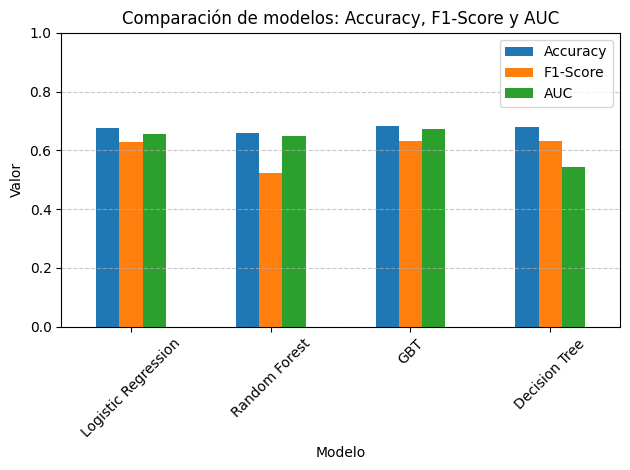

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir resultados a DataFrame
df_resultados = pd.DataFrame(resultados)

# Establecer índice como nombre de modelo
df_resultados.set_index("Modelo", inplace=True)

# Plot general
plt.figure(figsize=(10, 6))
df_resultados.plot.bar(rot=45)
plt.title("Comparación de modelos: Accuracy, F1-Score y AUC")
plt.ylim(0, 1)
plt.ylabel("Valor")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [18]:
from pyspark.ml.classification import GBTClassifier

# Entrenar GBT por separado
gbt = GBTClassifier(labelCol="DELAYED", featuresCol="features", maxIter=20)
gbt_model = gbt.fit(train_prepared)


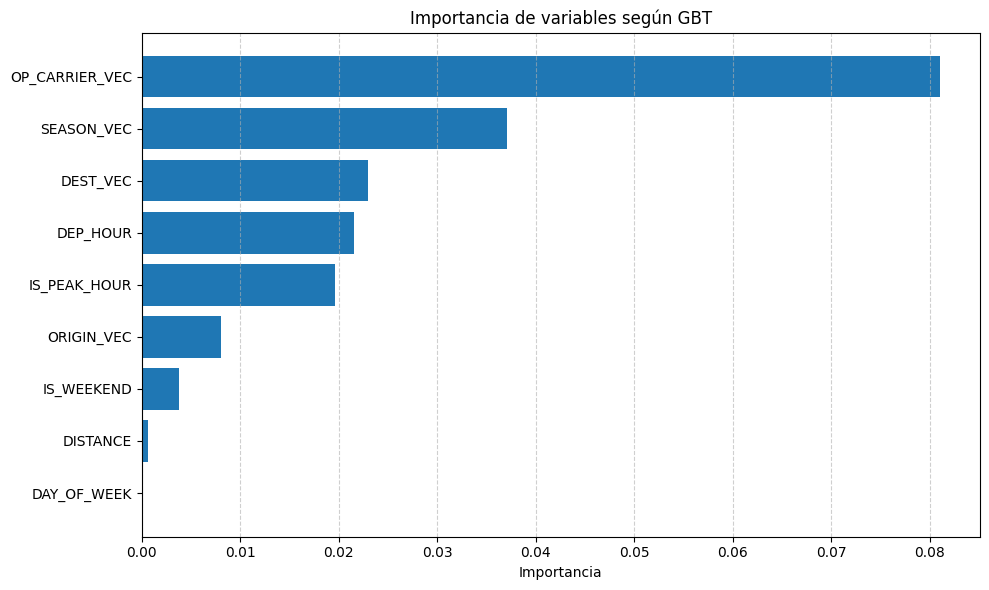

In [19]:
import numpy as np

# 1. Extraer importancia de variables
importancias = gbt_model.featureImportances.toArray()

# 2. Obtener nombres de entrada del vectorAssembler
feature_names = assembler.getInputCols()

# ⚠️ Si usaste OneHotEncoder, las columnas se expanden, así que este paso da una visión general.
# Para detalle fino, se requiere usar VectorSizeHint o manejar codificación manual.

# 3. Agrupar importancia por cada columna base
df_importancia = pd.DataFrame({
    'feature': feature_names,
    'importance': importancias[:len(feature_names)]  # Truncamos si hay más elementos por OHE
})

# 4. Ordenar por importancia
df_importancia.sort_values("importance", ascending=False, inplace=True)

# 5. Graficar
plt.figure(figsize=(10, 6))
plt.barh(df_importancia["feature"], df_importancia["importance"])
plt.title("Importancia de variables según GBT")
plt.xlabel("Importancia")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [20]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd

# 1. Definir modelo base
gbt = GBTClassifier(labelCol="DELAYED", featuresCol="features")

# 2. Definir grilla de hiperparámetros
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 7, 10]) \
    .addGrid(gbt.maxIter, [10, 20, 30]) \
    .build()

# 3. Evaluador
evaluator = BinaryClassificationEvaluator(labelCol="DELAYED", metricName="areaUnderROC")

# 4. Configurar CrossValidator
cv = CrossValidator(estimator=gbt,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3,
                    parallelism=2)

# 5. Entrenar con validación cruzada
cv_model = cv.fit(train_prepared)

# 6. Evaluar en test
predicciones_cv = cv_model.transform(test_prepared)
auc_final = evaluator.evaluate(predicciones_cv)
print(f"AUC del mejor modelo en test: {auc_final:.4f}")

# 7. Extraer combinaciones y sus AUCs
auc_scores = cv_model.avgMetrics
param_maps = paramGrid

# 8. Convertir a DataFrame
resultados_hp = []
for params, auc in zip(param_maps, auc_scores):
    resultados_hp.append({
        'maxDepth': params[gbt.maxDepth],
        'maxIter': params[gbt.maxIter],
        'AUC': auc
    })

df_hp = pd.DataFrame(resultados_hp)


25/06/18 17:05:33 WARN BlockManager: Asked to remove block broadcast_3195, which does not exist
25/06/18 17:12:38 WARN DAGScheduler: Broadcasting large task binary with size 1004.3 KiB
25/06/18 17:12:53 WARN DAGScheduler: Broadcasting large task binary with size 1000.0 KiB
25/06/18 17:12:55 WARN DAGScheduler: Broadcasting large task binary with size 1001.3 KiB
25/06/18 17:12:56 WARN DAGScheduler: Broadcasting large task binary with size 1003.7 KiB
25/06/18 17:12:59 WARN DAGScheduler: Broadcasting large task binary with size 1008.0 KiB
25/06/18 17:13:04 WARN DAGScheduler: Broadcasting large task binary with size 1015.1 KiB
25/06/18 17:13:08 WARN DAGScheduler: Broadcasting large task binary with size 1025.5 KiB
25/06/18 17:13:13 WARN DAGScheduler: Broadcasting large task binary with size 1041.5 KiB
25/06/18 17:13:20 WARN DAGScheduler: Broadcasting large task binary with size 1064.2 KiB
25/06/18 17:13:27 WARN DAGScheduler: Broadcasting large task binary with size 1025.4 KiB
25/06/18 17:21

AUC del mejor modelo en test: 0.6737


In [22]:
df_cv = df_hp.copy()  # ✅ Usa el DataFrame que ya generaste


   maxDepth  maxIter       AUC
2         5       30  0.669390
5         7       30  0.668296
1         5       20  0.668000
4         7       20  0.667299
3         7       10  0.664877
0         5       10  0.664580
7        10       20  0.659672
8        10       30  0.659560
6        10       10  0.658156


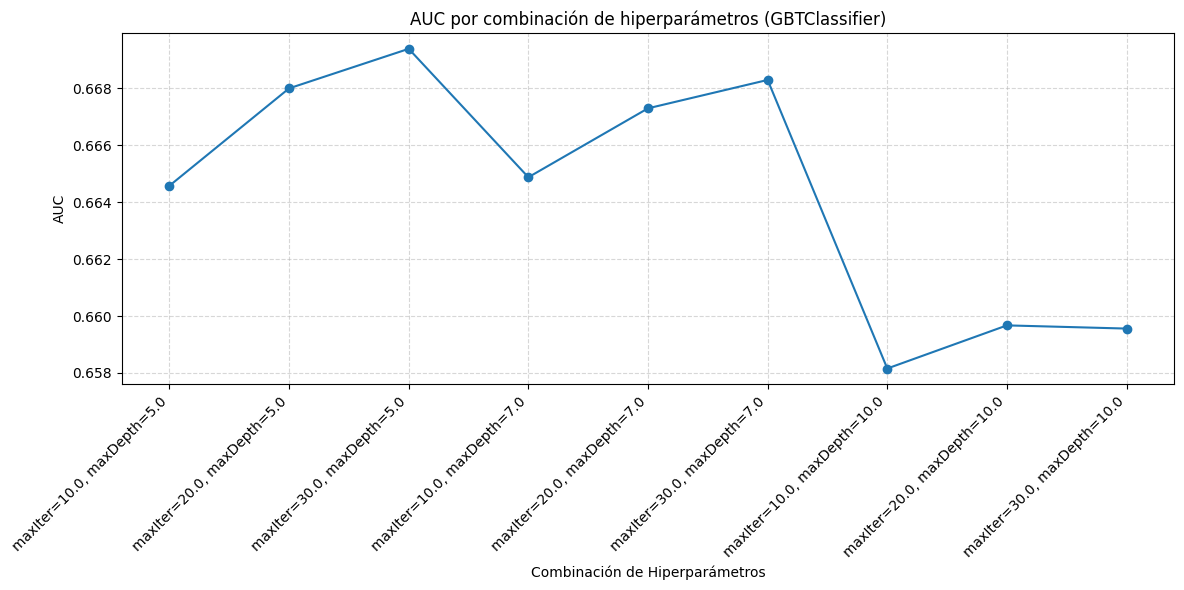

In [24]:
import pandas as pd
import matplotlib.pyplot as plt


# Mostrar ordenado por AUC (o F1 si lo tuvieras)
df_cv_sorted = df_cv.sort_values(by="AUC", ascending=False)
print(df_cv_sorted)

# Crear etiquetas legibles para cada combinación
df_cv["params"] = df_cv.apply(lambda row: f"maxIter={row['maxIter']}, maxDepth={row['maxDepth']}", axis=1)

# Graficar AUC por combinación de hiperparámetros
plt.figure(figsize=(12, 6))
plt.plot(df_cv["params"], df_cv["AUC"], marker='o', label="AUC")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Combinación de Hiperparámetros")
plt.ylabel("AUC")
plt.title("AUC por combinación de hiperparámetros (GBTClassifier)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Obtener datos de predicción
confusion_df = predicciones.groupBy("DELAYED", "prediction").count().toPandas()

# Crear matriz de confusión 2x2
mat = np.zeros((2, 2), dtype=int)
for _, row in confusion_df.iterrows():
    real = int(row["DELAYED"])
    pred = int(row["prediction"])
    mat[real][pred] = int(row["count"])

# Convertir a DataFrame con etiquetas legibles
conf_matrix = pd.DataFrame(mat,
    index=["Real ON TIME", "Real DELAYED"],
    columns=["Predicho ON TIME", "Predicho DELAYED"]
)


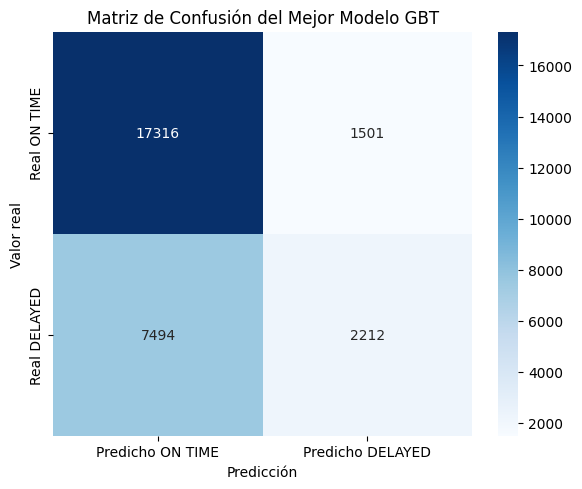

In [28]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Matriz de Confusión del Mejor Modelo GBT")
plt.ylabel("Valor real")
plt.xlabel("Predicción")
plt.tight_layout()
plt.show()


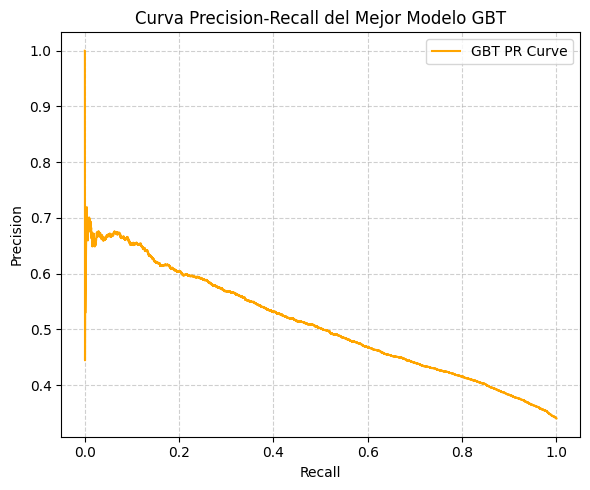

In [38]:
# 1. Obtener probabilidad y etiquetas reales
df_pred = predicciones.select("probability", "DELAYED").toPandas()
df_pred["score"] = df_pred["probability"].apply(lambda v: v[1])
df_pred["label"] = df_pred["DELAYED"]

# 2. Ordenar por score descendente
df_pred = df_pred.sort_values("score", ascending=False).reset_index(drop=True)

# 3. Calcular Precision y Recall en cada punto
precisions = []
recalls = []
tp = 0
fp = 0
total_positivos = df_pred["label"].sum()

for i in range(len(df_pred)):
    if df_pred.loc[i, "label"] == 1:
        tp += 1
    else:
        fp += 1
    precision = tp / (tp + fp)
    recall = tp / total_positivos
    precisions.append(precision)
    recalls.append(recall)

# 4. Graficar
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, color="orange", label="GBT PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall del Mejor Modelo GBT")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


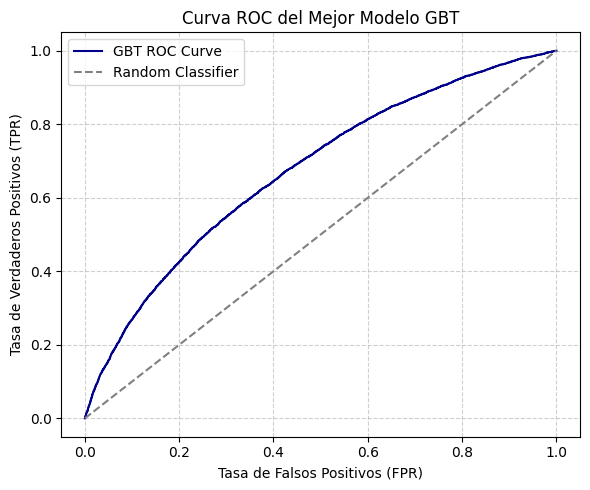

In [39]:
# Ya deberías tener esto:
# df_pred = predicciones.select("probability", "DELAYED").toPandas()
df_pred["score"] = df_pred["probability"].apply(lambda v: v[1])
df_pred["label"] = df_pred["DELAYED"]

# Ordenar por score descendente
df_pred = df_pred.sort_values("score", ascending=False).reset_index(drop=True)

# Inicializar variables
tpr_list = []
fpr_list = []
tp = 0
fp = 0
fn = df_pred["label"].sum()
tn = len(df_pred) - fn

for i in range(len(df_pred)):
    if df_pred.loc[i, "label"] == 1:
        tp += 1
        fn -= 1
    else:
        fp += 1
        tn -= 1
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr_list.append(tpr)
    fpr_list.append(fpr)

# Graficar
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(fpr_list, tpr_list, label="GBT ROC Curve", color="darkblue")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC del Mejor Modelo GBT")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
